Distance matrix:
 [[0.  1.1 3.  9.5]
 [1.1 0.  2.1 3.9]
 [3.  2.1 0.  5.7]
 [9.5 3.9 5.7 0. ]]


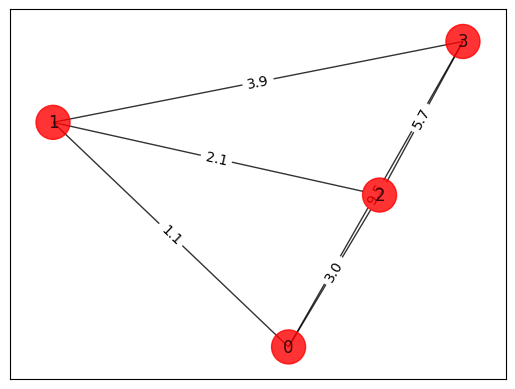

🔄 Optimizing QAOA parameters...
✅ Optimization complete.
🔎 Buscando la mejor ruta entre 1000 mediciones...
✅ Mejor ruta válida encontrada: (0, 2, 3, 1)


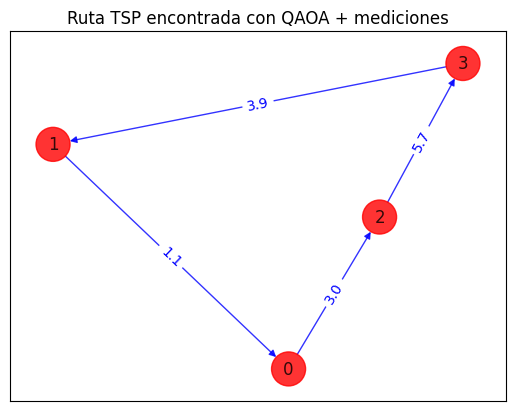

In [32]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

# -------- PARÁMETROS --------
n = 4
num_qubits = n * n
p = 2
A = 100

# -------- GRAFO ALEATORIO --------
G = nx.complete_graph(n)
pos = nx.spring_layout(G, seed=123)
for i in G.nodes():
    for j in G.nodes():
        if i != j:
            G[i][j]["weight"] = float(np.round(np.random.uniform(1, 10), 1))

adj_matrix = nx.to_numpy_array(G)
print("Distance matrix:\n", adj_matrix)

def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.show()

draw_graph(G, ["r"] * n, pos)

# -------- HAMILTONIANO TSP --------
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# -------- QAOA MANUAL + SIMULADOR CON SHOTS --------
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.expval(H)

# -------- OPTIMIZACIÓN --------
init_params = np.random.uniform(0, np.pi, (2, p))
init_params_flat = init_params.flatten()

def cost_fn_flat(params_flat):
    params = params_flat.reshape((2, p))
    return qaoa_circuit(params)

print("🔄 Optimizing QAOA parameters...")
opt_result = minimize(cost_fn_flat, x0=init_params_flat, method="COBYLA", options={"maxiter": 100})
opt_params = opt_result.x.reshape((2, p))
print("✅ Optimization complete.")

# -------- MEDICIONES CON SAMPLE --------
@qml.qnode(dev)
def sample_final(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.sample(wires=range(num_qubits))

samples = sample_final(opt_params)

# -------- FUNCIONES DE INTERPRETACIÓN --------
def interpret_and_validate(x, n):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    valid = sorted(order) == list(range(n))
    return tuple(order), valid

# -------- BUSCAR SOLUCIÓN MÁS FRECUENTE Y VÁLIDA --------
print("🔎 Buscando la mejor ruta entre 1000 mediciones...")
bitstrings = [tuple(sample.tolist()) for sample in samples]
valid_orders = []

for bit in bitstrings:
    order, valid = interpret_and_validate(np.array(bit), n)
    if valid:
        valid_orders.append(order)

if valid_orders:
    most_common_order = Counter(valid_orders).most_common(1)[0][0]
    print("✅ Mejor ruta válida encontrada:", most_common_order)
    
    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        for i in range(len(order)):
            j = (i + 1) % len(order)
            if order[i] in G and order[j] in G[order[i]]:
                G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        plt.figure()
        nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
        edge_labels = nx.get_edge_attributes(G2, "weight")
        nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
        plt.title("Ruta TSP encontrada con QAOA + mediciones")
        plt.show()

    draw_tsp_solution(G, most_common_order, ["r"] * n, pos)

else:
    print("❌ No se encontró ninguna ruta válida en las 1000 mediciones.")


Distance matrix:
 [[  0. 245. 302. 707.]
 [245.   0. 328. 531.]
 [302. 328.   0. 856.]
 [707. 531. 856.   0.]]


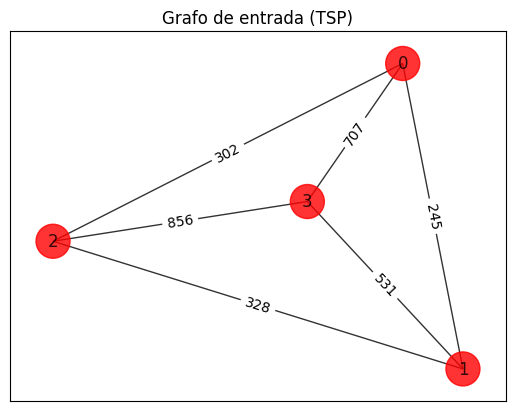

🔄 Optimizing QAOA parameters...
✅ Optimization complete.
🔎 Buscando la mejor ruta entre 1000 mediciones...
✅ Mejor ruta válida encontrada: (1, 2, 0, 3)


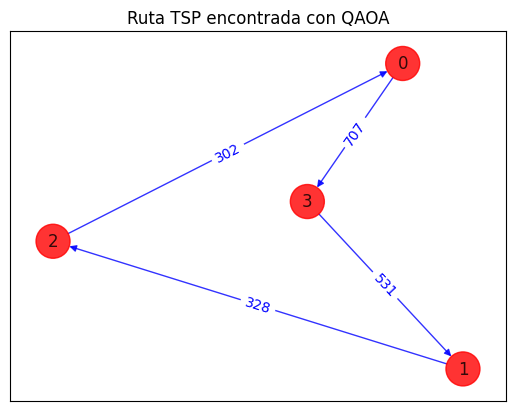

In [33]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

# -------- PARÁMETROS --------
n = 4
num_qubits = n * n
p = 2
A = 100

# -------- GRAFO PERSONALIZADO --------
edges = [(0, 1, 245), (0, 2, 302), (0, 3, 707), (1, 2, 328), (1, 3, 531), (2, 3, 856)]
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Distance matrix:\n", adj_matrix)

def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.title("Grafo de entrada (TSP)")
    plt.show()

draw_graph(G, ["r"] * n, pos)

# -------- HAMILTONIANO TSP --------
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# -------- QAOA CON MEDICIÓN --------
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.expval(H)

# -------- OPTIMIZACIÓN --------
init_params = np.random.uniform(0, np.pi, (2, p))
init_params_flat = init_params.flatten()

def cost_fn_flat(params_flat):
    params = params_flat.reshape((2, p))
    return qaoa_circuit(params)

print("🔄 Optimizing QAOA parameters...")
opt_result = minimize(cost_fn_flat, x0=init_params_flat, method="COBYLA", options={"maxiter": 100})
opt_params = opt_result.x.reshape((2, p))
print("✅ Optimization complete.")

# -------- MEDICIONES CON SAMPLE --------
@qml.qnode(dev)
def sample_final(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.sample(wires=range(num_qubits))

samples = sample_final(opt_params)

# -------- FUNCIONES AUXILIARES --------
def interpret_and_validate(x, n):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    valid = sorted(order) == list(range(n))
    return tuple(order), valid

# -------- FILTRAR Y GRAFICAR --------
print("🔎 Buscando la mejor ruta entre 1000 mediciones...")
bitstrings = [tuple(sample.tolist()) for sample in samples]
valid_orders = []

for bit in bitstrings:
    order, valid = interpret_and_validate(np.array(bit), n)
    if valid:
        valid_orders.append(order)

if valid_orders:
    most_common_order = Counter(valid_orders).most_common(1)[0][0]
    print("✅ Mejor ruta válida encontrada:", most_common_order)

    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        for i in range(len(order)):
            j = (i + 1) % len(order)
            if order[i] in G and order[j] in G[order[i]]:
                G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        plt.figure()
        nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
        edge_labels = nx.get_edge_attributes(G2, "weight")
        nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
        plt.title("Ruta TSP encontrada con QAOA")
        plt.show()

    draw_tsp_solution(G, most_common_order, ["r"] * n, pos)

else:
    print("❌ No se encontró ninguna ruta válida en las 1000 mediciones.")


In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

Distance matrix:
 [[  0. 245. 302. 707.]
 [245.   0. 328. 531.]
 [302. 328.   0. 856.]
 [707. 531. 856.   0.]]


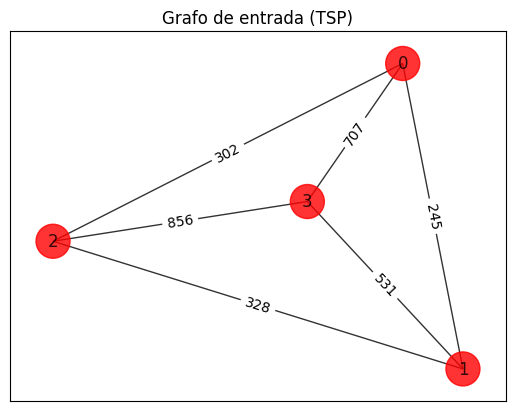

🔄 Optimizing QAOA parameters...
✅ Optimization complete.
🔎 Buscando la mejor ruta entre 1000 mediciones...
✅ Mejor ruta válida encontrada: (1, 3, 2, 0)


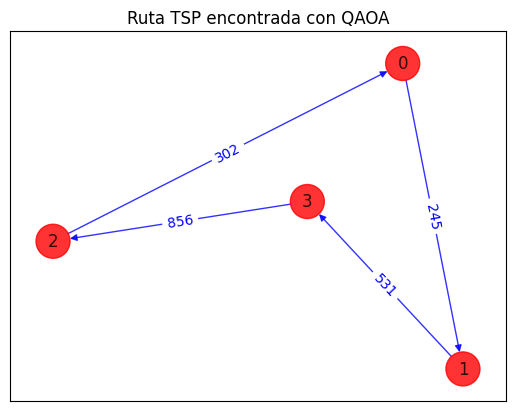

In [2]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

# -------- PARÁMETROS --------
n = 4
num_qubits = n * n
p = 2
A = 100

# -------- GRAFO PERSONALIZADO --------
edges = [(0, 1, 245), (0, 2, 302), (0, 3, 707), (1, 2, 328), (1, 3, 531), (2, 3, 856)]
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Distance matrix:\n", adj_matrix)

def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.title("Grafo de entrada (TSP)")
    plt.show()

draw_graph(G, ["r"] * n, pos)

# -------- HAMILTONIANO TSP --------
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# -------- QAOA CON MEDICIÓN --------
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.expval(H)

# -------- OPTIMIZACIÓN --------
init_params = np.random.uniform(0, np.pi, (2, p))
init_params_flat = init_params.flatten()

def cost_fn_flat(params_flat):
    params = params_flat.reshape((2, p))
    return qaoa_circuit(params)

print("🔄 Optimizing QAOA parameters...")
opt_result = minimize(cost_fn_flat, x0=init_params_flat, method="COBYLA", options={"maxiter": 100})
opt_params = opt_result.x.reshape((2, p))
print("✅ Optimization complete.")

# -------- MEDICIONES CON SAMPLE --------
@qml.qnode(dev)
def sample_final(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.sample(wires=range(num_qubits))

samples = sample_final(opt_params)

# -------- FUNCIONES AUXILIARES --------
def interpret_and_validate(x, n):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    valid = sorted(order) == list(range(n))
    return tuple(order), valid

# -------- FILTRAR Y GRAFICAR --------
print("🔎 Buscando la mejor ruta entre 1000 mediciones...")
bitstrings = [tuple(sample.tolist()) for sample in samples]
valid_orders = []

for bit in bitstrings:
    order, valid = interpret_and_validate(np.array(bit), n)
    if valid:
        valid_orders.append(order)

if valid_orders:
    most_common_order = Counter(valid_orders).most_common(1)[0][0]
    print("✅ Mejor ruta válida encontrada:", most_common_order)

    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        for i in range(len(order)):
            j = (i + 1) % len(order)
            if order[i] in G and order[j] in G[order[i]]:
                G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        plt.figure()
        nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
        edge_labels = nx.get_edge_attributes(G2, "weight")
        nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
        plt.title("Ruta TSP encontrada con QAOA")
        plt.show()

    draw_tsp_solution(G, most_common_order, ["r"] * n, pos)

else:
    print("❌ No se encontró ninguna ruta válida en las 1000 mediciones.")

(<Figure size 800x1700 with 1 Axes>, <Axes: >)

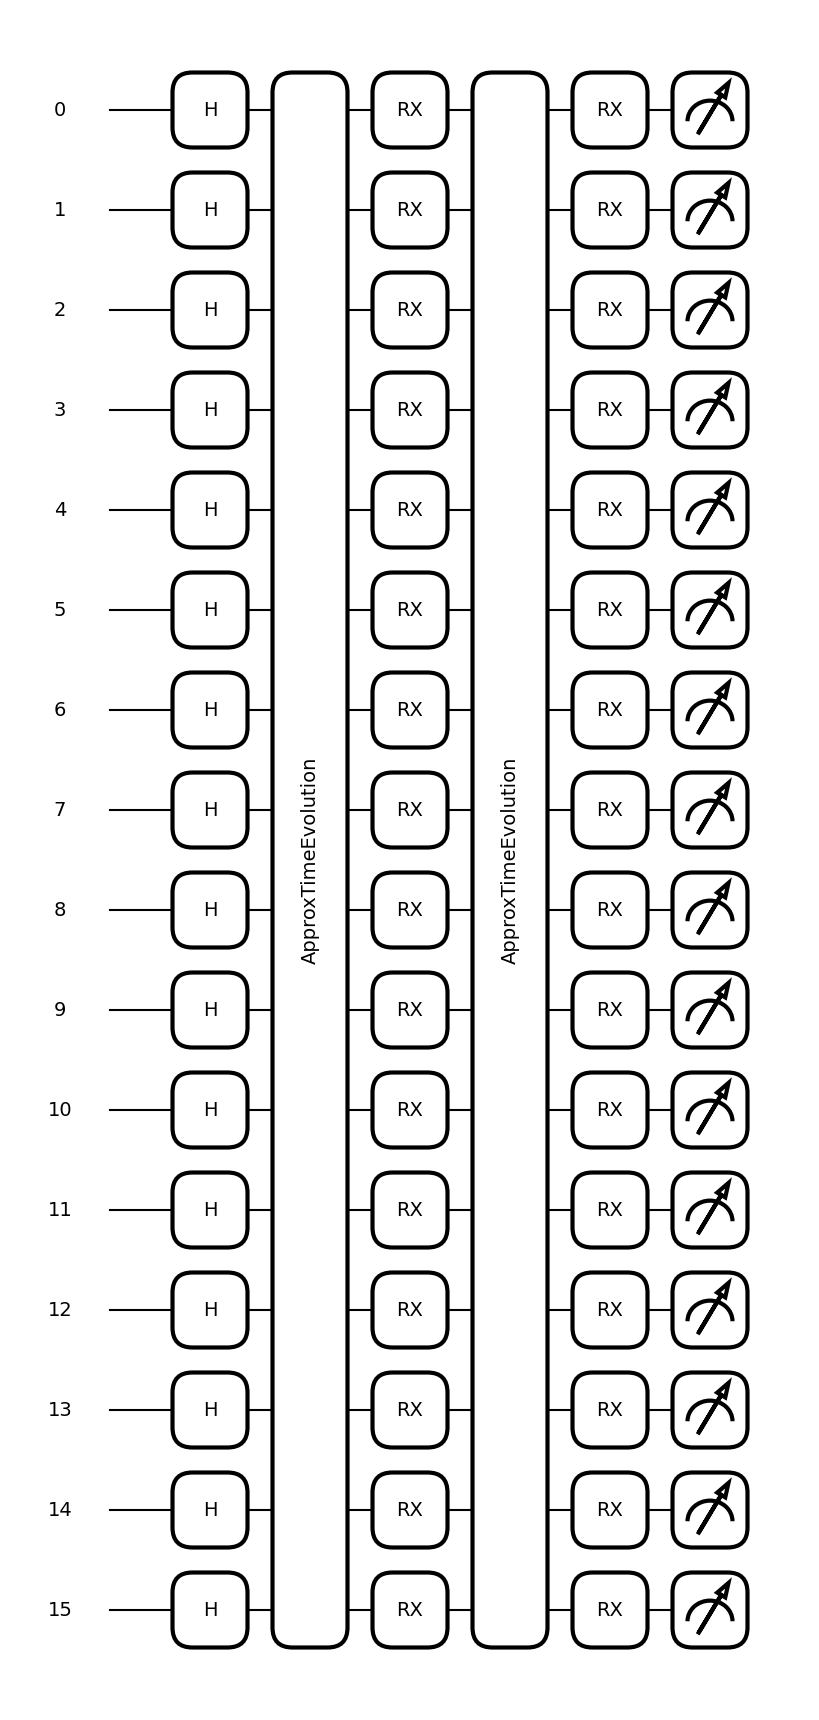

In [4]:
from pennylane.drawer import draw_mpl

draw_mpl(qaoa_circuit)(opt_params)

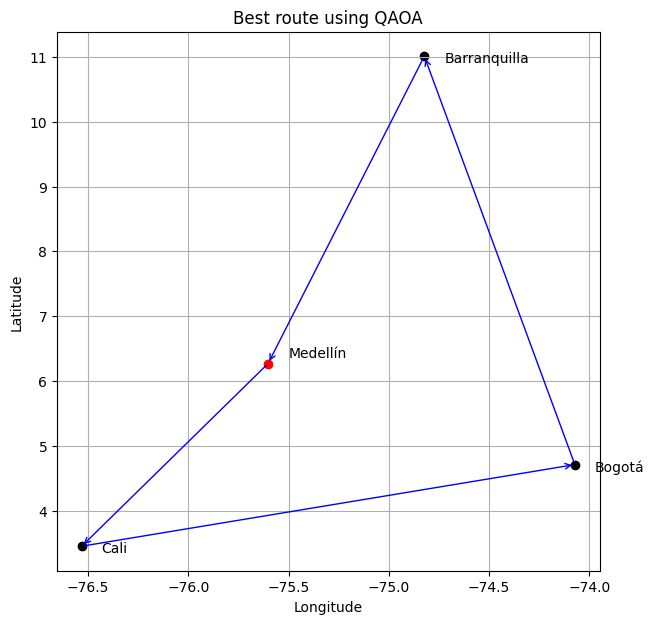

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the city names and their coordinates (fake sample data)
city_names = {0: 'Bogotá', 1: 'Medellín', 2: 'Cali', 3: 'Barranquilla'}
coordinates = {
    'Bogotá': {'Latitude': 4.711011, 'Longitude': -74.0720917},
    'Medellín': {'Latitude': 6.269732449999999, 'Longitude': -75.60255965090315},
    'Cali': {'Latitude': 3.4519988, 'Longitude': -76.5325259},
    'Barranquilla': {'Latitude': 11.0101922, 'Longitude': -74.8231794084391}
}

# Create a DataFrame with the city coordinates
df_cities = pd.DataFrame(coordinates).T

# Use the route from QAOA output
best_order = (1, 2, 0, 3)  # This is the route found by QAOA

# Draw the route on a map
plt.figure(figsize=(7, 7))

# Draw cities
for city, row in df_cities.iterrows():
    color = 'r' if city == 'Medellín' else 'black'
    dy = 0.1 if city == 'Medellín' else -0.1
    plt.scatter(row['Longitude'], row['Latitude'], c=color)
    plt.text(row['Longitude'] + 0.1, row['Latitude'] + dy, city, fontsize=10)

# Draw arrows for the route
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i in range(len(best_order)):
    start = city_names[best_order[i]]
    end = city_names[best_order[(i + 1) % len(best_order)]]
    plt.annotate(
        '', 
        xy=[df_cities.loc[end]['Longitude'], df_cities.loc[end]['Latitude']],
        xytext=[df_cities.loc[start]['Longitude'], df_cities.loc[start]['Latitude']],
        arrowprops=arrowprops
    )

plt.title('Best route using QAOA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
